In [20]:
!pip3 install xarray
!pip3 install zarr


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [21]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [22]:
plt.style.use("sans_style_ppt.mplstyle")

OSError: 'sans_style_ppt.mplstyle' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [23]:
data_path = "BayesianEstimationDecayRate_162937"

data = xr.open_zarr(os.path.join(data_path, "raw_data.zarr"))

In [4]:
data

<xarray.Dataset> Size: 168MB
Dimensions:        (repetitions: 50000, shots: 30)
Coordinates:
  * repetitions    (repetitions) int32 200kB 0 1 2 3 ... 49996 49997 49998 49999
  * shots          (shots) int32 120B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
Data variables: (12/14)
    q3             (repetitions, shots) float64 12MB ...
    q3__timestamp  (repetitions, shots) float64 12MB ...
    q3_gamma       (repetitions, shots) float64 12MB ...
    q3_k           (repetitions, shots) float64 12MB ...
    q3_state       (repetitions, shots) float64 12MB ...
    q3_theta       (repetitions, shots) float64 12MB ...
    ...             ...
    q5__timestamp  (repetitions, shots) float64 12MB ...
    q5_gamma       (repetitions, shots) float64 12MB ...
    q5_k           (repetitions, shots) float64 12MB ...
    q5_state       (repetitions, shots) float64 12MB ...
    q5_theta       (repetitions, shots) float64 12MB ...
    q5_time        (repetitions, shots) float64 12MB ...
Attributes:
    job_id:      c3dcdd56-c1de-4a1b-ba28-20836de9ce96
    job_status:  completed

In [24]:
theta_q3 = np.reshape(
    (data.q3_theta.values.flatten()),
    (
        len(data.q3_theta.values.flatten()) // (data.shots.values[-1] + 1),
        data.shots.values[-1] + 1,
    ),
)
k_q3 = np.reshape(
    (data.q3_k.values.flatten()),
    (
        len(data.q3_k.values.flatten()) // (data.shots.values[-1] + 1),
        data.shots.values[-1] + 1,
    ),
)

theta_q5 = np.reshape(
    (data.q5_theta.values.flatten()),
    (
        len(data.q5_theta.values.flatten()) // (data.shots.values[-1] + 1),
        data.shots.values[-1] + 1,
    ),
)
k_q5 = np.reshape(
    (data.q5_k.values.flatten()),
    (
        len(data.q5_k.values.flatten()) // (data.shots.values[-1] + 1),
        data.shots.values[-1] + 1,
    ),
)

lab_time_s = np.reshape(
    data.q3__timestamp.values.flatten(),
    (
        len(data.q3__timestamp.values.flatten()) // (data.shots.values[-1] + 1),
        data.shots.values[-1] + 1,
    ),
)[:, 0]

In [25]:
t1_q3_us = (theta_q3 / (16 * k_q3) * 1e6)[:, -1]
t1_q5_us = (theta_q5 / (16 * k_q5) * 1e6)[:, -1]

In [26]:
my_colors = {
    "red": "#FF1F5B",
    "green": "#00CD6C",
    "blue": "#009ADE",
    "purple": "#AF58BA",
    "yellow": "#FFC61E",
    "orange": "#F28522",
    "gray": "#A0B1BA",
    "Q3": "#FF1F5B",
    "Q5": "#009ADE",
}

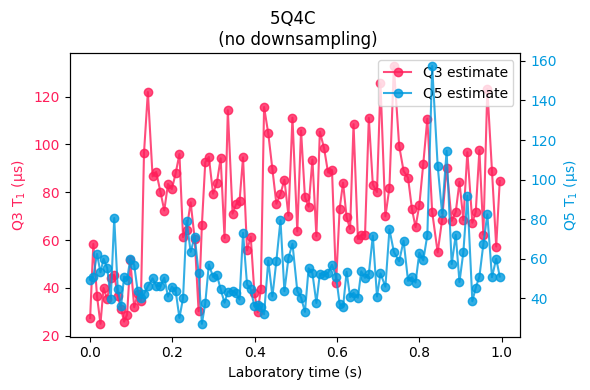

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))


plot_first_N_seconds = 1

# Filter data for the first second
mask_q3 = lab_time_s <= plot_first_N_seconds
ax.plot(
    lab_time_s[mask_q3],
    t1_q3_us[mask_q3],
    color=my_colors["red"],
    linestyle="-",
    marker="o",
    label=f"Q3 estimate",
    alpha=0.8,
)

ax.set_xlabel("Laboratory time (s)")
ax.set_ylabel(f"Q3 T$_1$ (µs)", color=my_colors["red"])
ax.tick_params(axis="y", labelcolor=my_colors["red"])

# Right axis for Q5

# Compute moving average for Q5

# Filter data for the first second
mask_q5 = lab_time_s <= plot_first_N_seconds
ax_right = ax.twinx()
ax_right.plot(
    lab_time_s[mask_q5],
    t1_q5_us[mask_q5],
    color=my_colors["blue"],
    linestyle="-",
    marker="o",
    label=f"Q5 estimate",
    alpha=0.8,
)

ax_right.set_ylabel(f"Q5 T$_1$ (µs)", color=my_colors["blue"])
ax_right.tick_params(axis="y", labelcolor=my_colors["blue"])

plt.title(f"5Q4C \n (no downsampling)")
# Add legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper right")

plt.tight_layout()

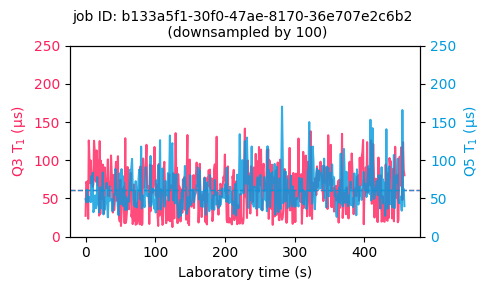

In [28]:
fig, ax = plt.subplots(figsize=(5, 3))

downsample_factor = 100
downsampled_lab_time = lab_time_s[::downsample_factor]
downsampled_expected_T1_q3 = t1_q3_us[::downsample_factor]

mean_val_q3 = np.mean(downsampled_expected_T1_q3)
ax.plot(
    downsampled_lab_time,
    downsampled_expected_T1_q3,
    color=my_colors["red"],
    label=f"q3 estimate",
    alpha=0.8,
)
ax.axhline(
    y=mean_val_q3,
    color=my_colors["red"],
    linestyle="--",
    linewidth=1.0,
    alpha=0.8,
    label=f"Q3 mean T$_1$ = {mean_val_q3:.1f} µs",
)
ax.set_xlabel("Laboratory time (s)")
ax.set_ylabel(f"Q3 T$_1$ (µs)", color=my_colors["red"])
ax.tick_params(axis="y", labelcolor=my_colors["red"])
ax.set_ylim(0, 250)

# Right axis for Q5
ax_right = ax.twinx()
downsampled_expected_T1_q5 = t1_q5_us[::downsample_factor]

mean_val_q5 = np.nanmean(downsampled_expected_T1_q5)
ax_right.plot(
    downsampled_lab_time,
    downsampled_expected_T1_q5,
    color=my_colors["blue"],
    label=f"Q5 estimate",
    alpha=0.8,
)
ax_right.axhline(
    y=mean_val_q5,
    color=my_colors["blue"],
    linestyle="--",
    linewidth=1.0,
    alpha=0.8,
    label=f"Q5 mean T$_1$ = {mean_val_q5:.1f} µs",
)
ax_right.set_ylabel(f"Q5 T$_1$ (µs)", color=my_colors["blue"])
ax_right.tick_params(axis="y", labelcolor=my_colors["blue"])
ax_right.set_ylim(0, 250)

plt.title(f"job ID: {data.job_id} \n (downsampled by {downsample_factor})", fontsize=10)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
# ax.legend(lines + lines2, labels + labels2, loc="upper right")

plt.tight_layout()

In [29]:
from scipy.signal import correlate

In [30]:
from scipy.stats import zscore

In [31]:

# --- Parameters ---
window_size_sec = 1  # size of sliding window in seconds
relative_drop_threshold = 0.6  # drop (relative)
drop_coincidence_tolerance = 0.03  # seconds

# --- 1. Detect Sudden Drops (Relative) ---
rel_drop_q3 = (np.diff(t1_q3_us) / t1_q3_us[:-1])  # fractional change
rel_drop_q5 = (np.diff(t1_q5_us) / t1_q5_us[:-1])
drop_mask = (rel_drop_q3 < -relative_drop_threshold) & (rel_drop_q5 < -relative_drop_threshold)
event_times = lab_time_s[1:][drop_mask]

# --- 2. Sliding Window Cross-Correlation ---
sampling_interval = np.median(np.diff(lab_time_s))
window_size_pts = int(window_size_sec / sampling_interval)
lags = np.arange(0, window_size_pts)

corr_matrix = []
window_centers = []

for start in range(0, len(t1_q3_us) - window_size_pts):
    end = start + window_size_pts
    x = zscore(t1_q3_us[start:end])
    y = zscore(t1_q5_us[start:end])
    corr = correlate(x, y, mode="full") / window_size_pts
    mid = len(corr) // 2
    corr_pos = corr[mid : mid + window_size_pts]
    corr_matrix.append(corr_pos)
    window_centers.append(lab_time_s[start + window_size_pts // 2])

corr_matrix = np.array(corr_matrix)
window_centers = np.array(window_centers)
max_corr = np.max(np.abs(corr_matrix), axis=1)

In [32]:
min_correlation_threshold = 0.3  # for flagging correlation bursts
# --- 3. Flag Events Based on Cross-Correlation ---
# Keep only the events where cross-correlation exceeds the threshold
correlated_event_mask = max_corr > min_correlation_threshold
correlated_event_times = window_centers[correlated_event_mask]

# --- 4. Combine Sudden Drops and Cross-Correlation Bursts ---
# Now flag the events only when both conditions are met
final_event_mask = drop_mask & np.isin(lab_time_s[1:], correlated_event_times)

# Filter event times based on the combined criteria
final_event_times = lab_time_s[1:][final_event_mask]
len(final_event_times)  # Number of events detected

0

Text(0, 0.5, 'Count')

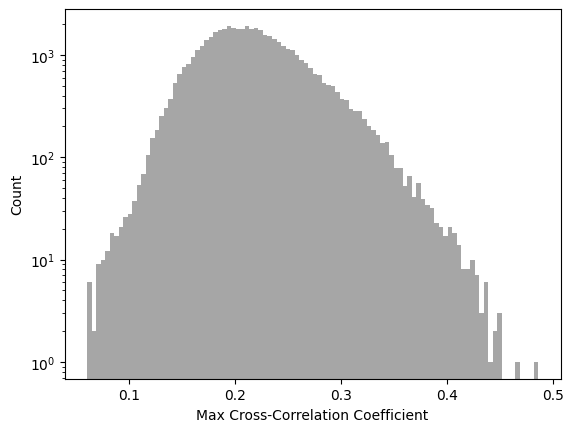

In [33]:
plt.hist(max_corr, bins=100, color="gray", alpha=0.7)
# y axis log
plt.yscale("log")
plt.xlabel("Max Cross-Correlation Coefficient")
plt.ylabel("Count")

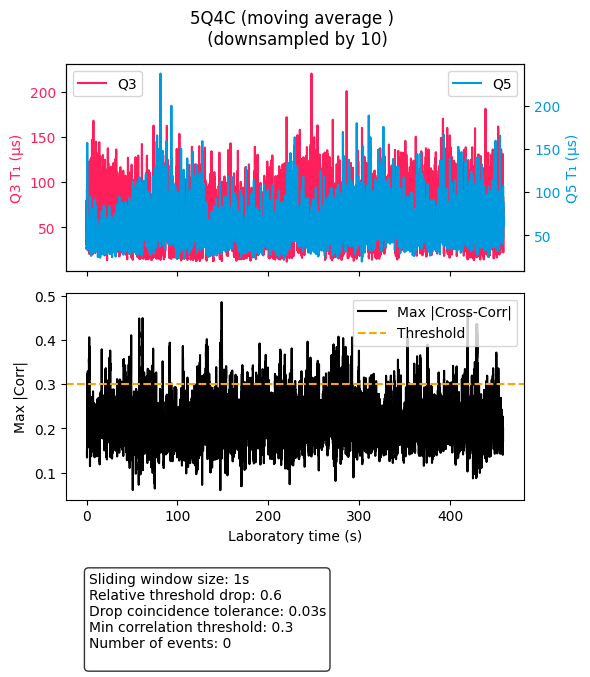

In [34]:
downsample_factor = 10  # adjust as needed
# --- 5. Plot Detected Events & Correlations ---
fig, ax = plt.subplots(2, 1, figsize=(6, 7), sharex=True)

# a. T₁ traces with flagged event markers
ax[0].plot(
    lab_time_s[::downsample_factor],
    t1_q3_us[::downsample_factor],
    color=my_colors["Q3"],
    label="Q3",
)
ax[0].set_ylabel("Q3 T₁ (µs)", color=my_colors["Q3"])
ax[0].tick_params(axis="y", labelcolor=my_colors["Q3"])
ax[0].legend(loc="upper left")

# Create a secondary y-axis for Q5
ax0_right = ax[0].twinx()
ax0_right.plot(
    lab_time_s[::downsample_factor],
    t1_q5_us[::downsample_factor],
    color=my_colors["Q5"],
    label="Q5",
)
ax0_right.set_ylabel("Q5 T₁ (µs)", color=my_colors["Q5"])
ax0_right.tick_params(axis="y", labelcolor=my_colors["Q5"])
ax0_right.legend(loc="upper right")

for t in final_event_times:
    ax[0].axvline(t, color="gray", linestyle="--", alpha=0.5)

# b. Cross-correlation over time
ax[1].plot(
    window_centers, max_corr, color="k", label="Max |Cross-Corr|", rasterized=True
)
ax[1].axhline(
    min_correlation_threshold, color="orange", linestyle="--", label="Threshold"
)
ax[1].set_xlabel("Laboratory time (s)")
ax[1].set_ylabel("Max |Corr|")
ax[1].legend()
# ax[1].set_ylim(0, 1)

plt.suptitle(f"5Q4C (moving average ) \n (downsampled by {downsample_factor})")
# Add a legend with the specified values
textstr = (
    f"Sliding window size: {window_size_sec}s\n"
    f"Relative threshold drop: {relative_drop_threshold} \n"
    f"Drop coincidence tolerance: {drop_coincidence_tolerance}s\n"
    f"Min correlation threshold: {min_correlation_threshold}\n"
    f"Number of events: {len(final_event_times)}\n"
)
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
ax[1].text(
    0.05,
    -0.35,
    textstr,
    transform=ax[1].transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)

plt.tight_layout()

In [35]:
import random
from matplotlib.ticker import MaxNLocator

# Set random seed for reproducibility
random.seed(42)

# Select 5 random events
if len(final_event_times) == 0:
    print("No events detected.")
else:
    selected_events = random.sample(
        list(final_event_times), min(5, len(final_event_times))
    )

    fig, axs = plt.subplots(
        len(selected_events), 1, figsize=(6, 3 * len(selected_events))
    )

    if len(selected_events) == 1:
        axs = [axs]  # Ensure axs is iterable for a single event

    for i, (ax, t) in enumerate(zip(axs, selected_events)):
        idx = np.where((lab_time_s >= t - 0.3) & (lab_time_s <= t + 0.3))[0]
        if len(idx) < 2:
            continue

        # Plot q3 on the left axis
        ax.plot(
            lab_time_s[idx], t1_q3_us[idx], color=my_colors["Q3"], label="Q3", alpha=0.7
        )
        ax.set_ylabel("Q3 T₁ (µs)", color=my_colors["Q3"])
        ax.tick_params(axis="y", labelcolor=my_colors["Q3"])

        # Plot Q5 on the right axis
        ax_right = ax.twinx()
        ax_right.plot(
            lab_time_s[idx], t1_q5_us[idx], color=my_colors["Q5"], label="Q5", alpha=0.7
        )
        ax_right.set_ylabel("Q5 T₁ (µs)", color=my_colors["Q5"])
        ax_right.tick_params(axis="y", labelcolor=my_colors["Q5"])

        ax.set_title(f"Event {i+1}: t ≈ {t:.2f} s")
        ax.grid(True)
        # Draw vertical line at event time
        ax.axvline(t, color="k", linestyle="--")

        # Set x-axis label only on the last subplot
        if i == len(selected_events) - 1:
            ax.set_xlabel("Laboratory time (s)")
        # Reduce number of x ticks
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))

    plt.tight_layout()

No events detected.


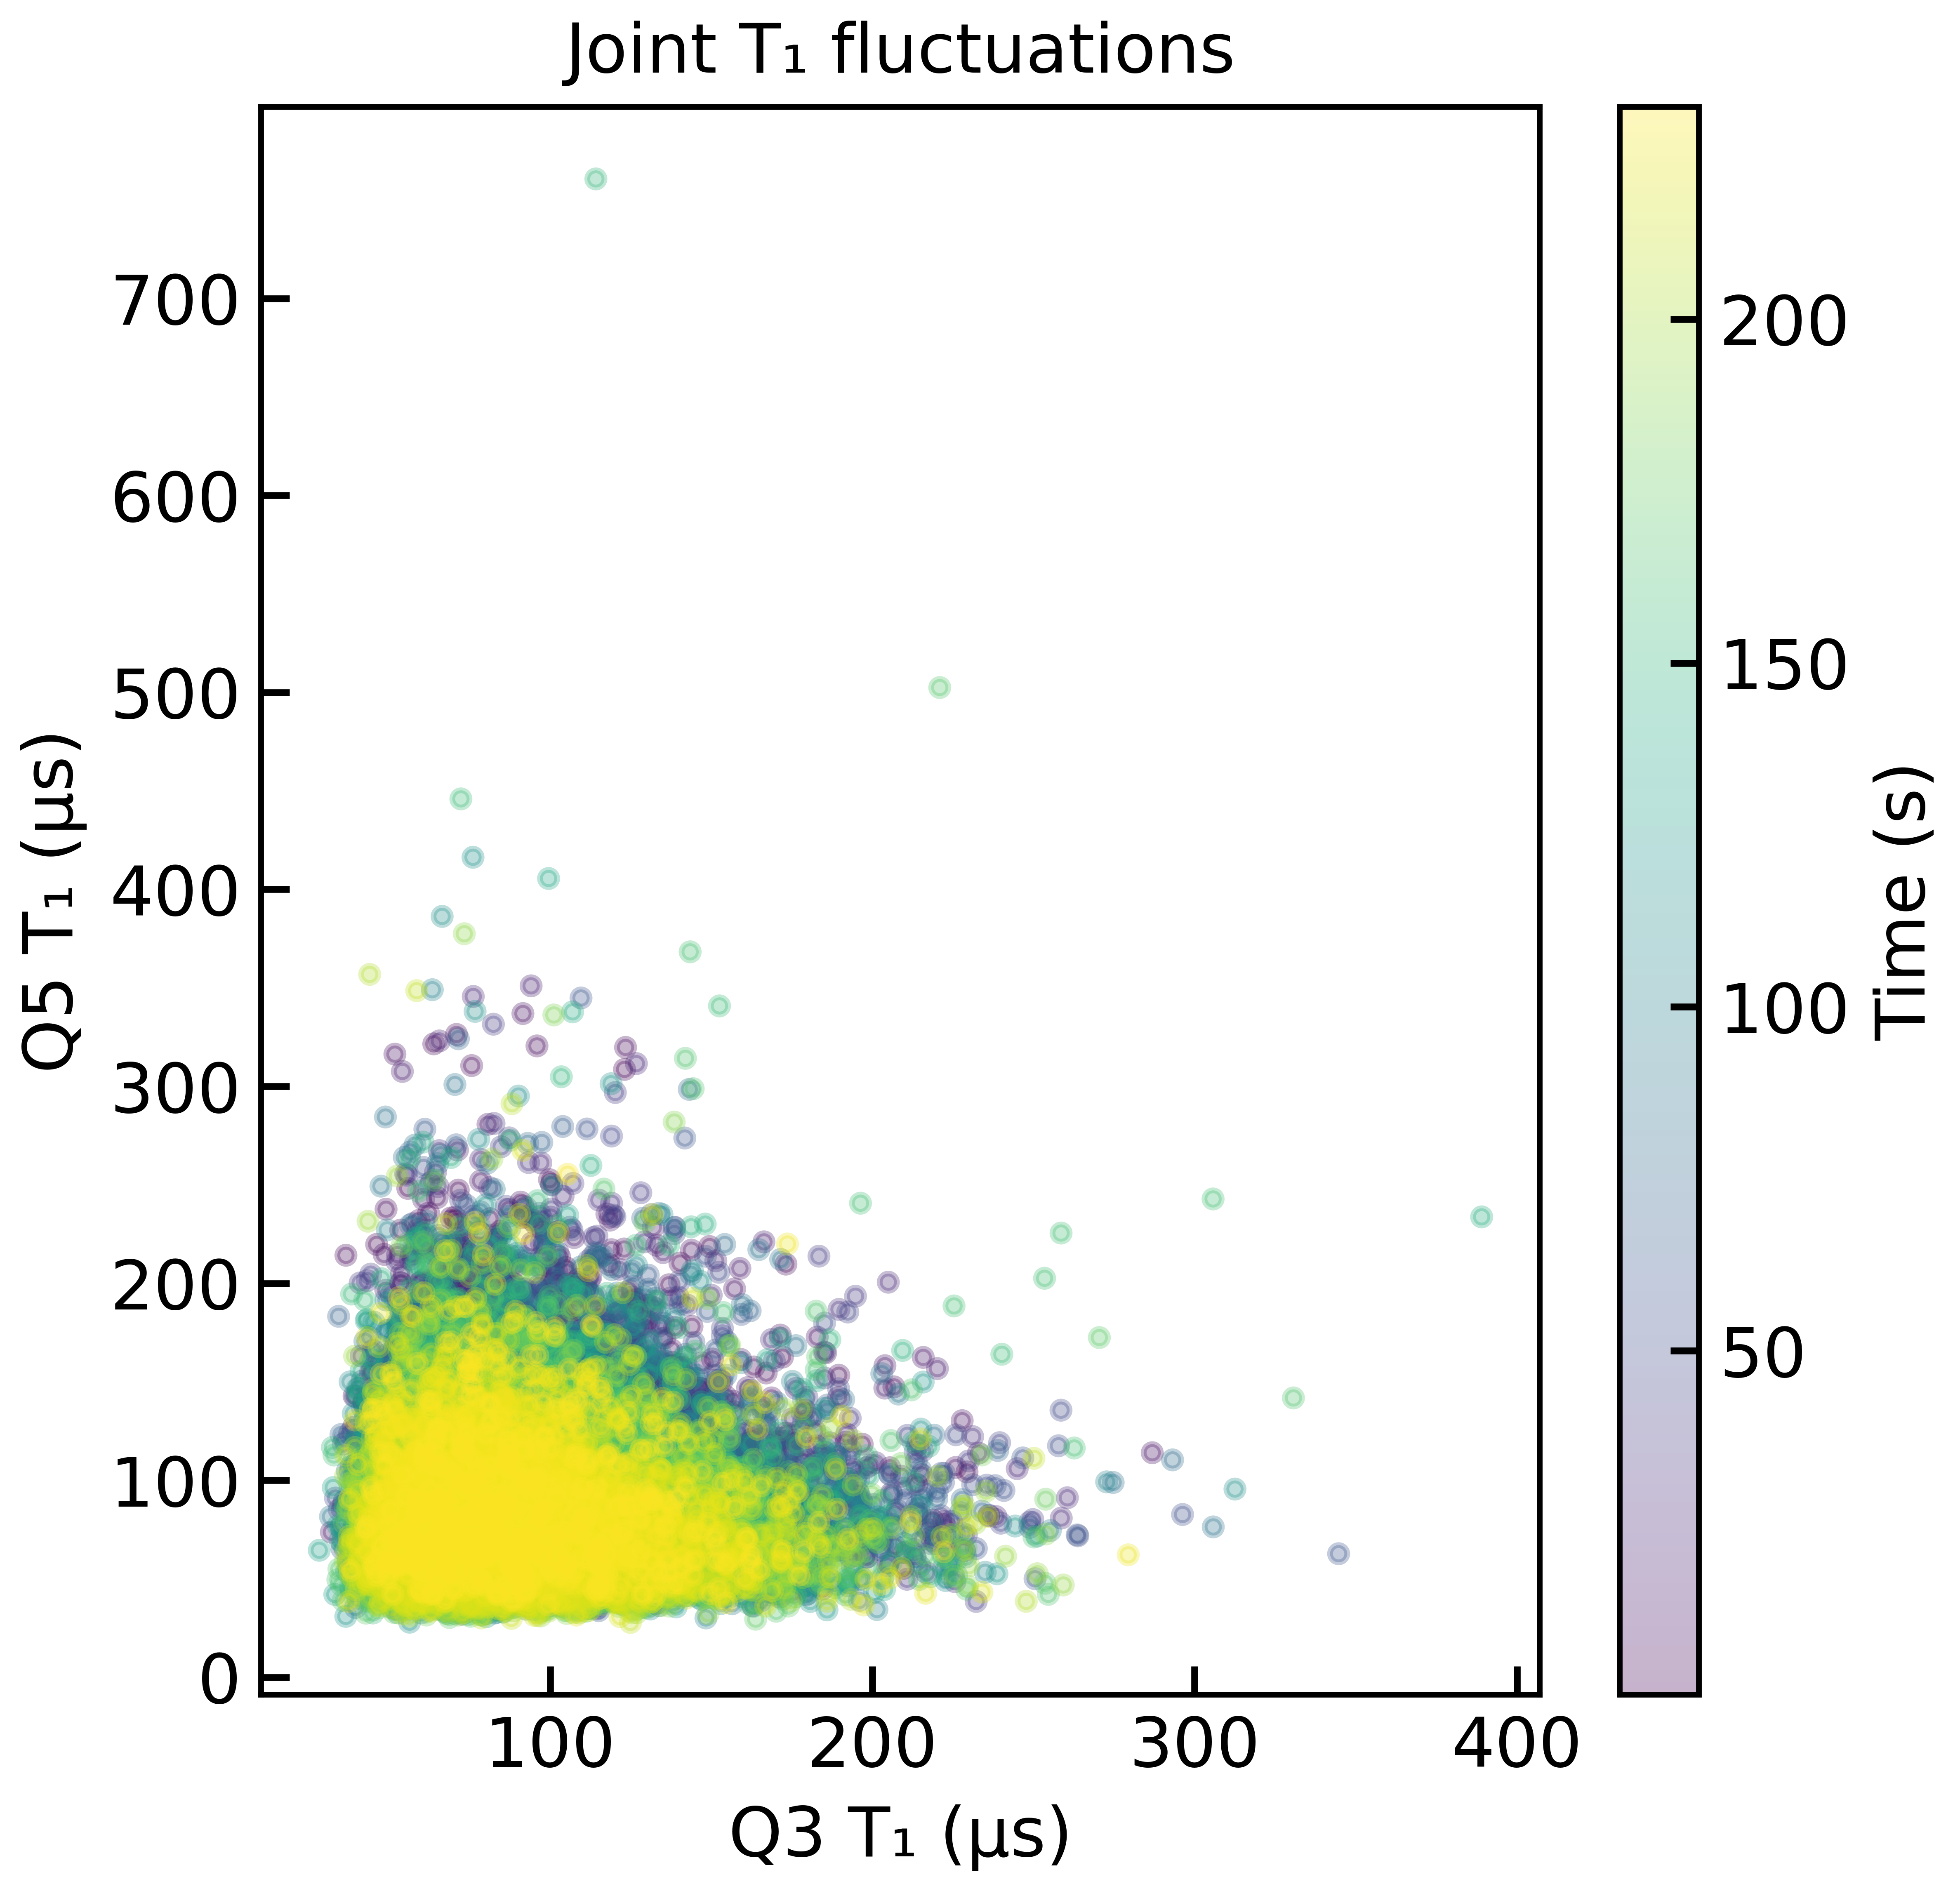

In [18]:
plt.figure(figsize=(5, 5))
plt.scatter(t1_q3_us, t1_q5_us, alpha=0.3, c=lab_time_s, cmap="viridis")
plt.xlabel("Q3 T₁ (µs)")
plt.ylabel("Q5 T₁ (µs)")
plt.colorbar(label="Time (s)")
plt.title("Joint T₁ fluctuations")
plt.show()

Text(0.5, 1.0, 'Sliding-window correlation map')

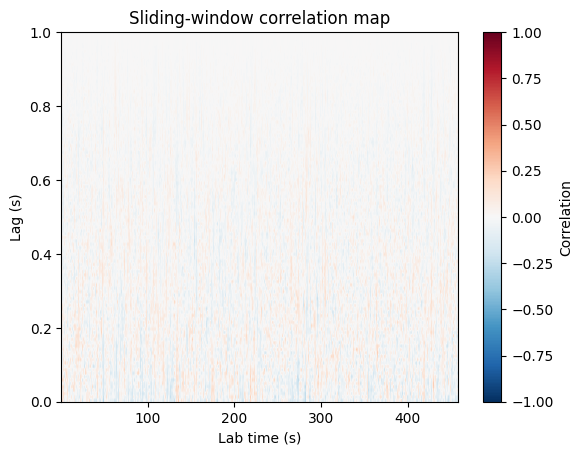

In [36]:
plt.imshow(
    corr_matrix.T,
    aspect="auto",
    origin="lower",
    extent=[window_centers[0], window_centers[-1], 0, window_size_sec],
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar(label="Correlation")
plt.xlabel("Lab time (s)")
plt.ylabel("Lag (s)")
plt.title("Sliding-window correlation map")

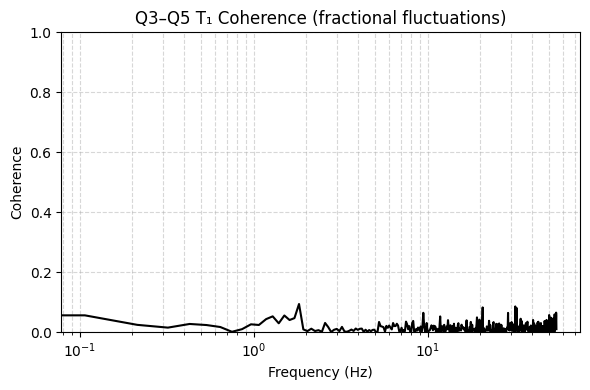

In [37]:
# %% -------------------------------
# FRACTIONAL FLUCTUATIONS & COHERENCE
# %% -------------------------------
from scipy.signal import welch, csd

# Normalize T1 traces to fractional fluctuations (delta T1 / mean)
norm_t1_q3 = (t1_q3_us - np.mean(t1_q3_us)) / np.mean(t1_q3_us)
norm_t1_q5 = (t1_q5_us - np.mean(t1_q5_us)) / np.mean(t1_q5_us)

# Sampling frequency from lab_time_s
fs = 1.0 / np.median(np.diff(lab_time_s))

# Welch PSDs
f, Pxx = welch(norm_t1_q3, fs=fs, nperseg=1024)
_, Pyy = welch(norm_t1_q5, fs=fs, nperseg=1024)

# Cross spectral density
_, Pxy = csd(norm_t1_q3, norm_t1_q5, fs=fs, nperseg=1024)

# Magnitude-squared coherence
coherence = np.abs(Pxy) ** 2 / (Pxx * Pyy)

# Plot coherence
plt.figure(figsize=(6, 4))
plt.semilogx(f, coherence, color="k")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.title("Q3–Q5 T₁ Coherence (fractional fluctuations)")
plt.ylim(0, 1)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

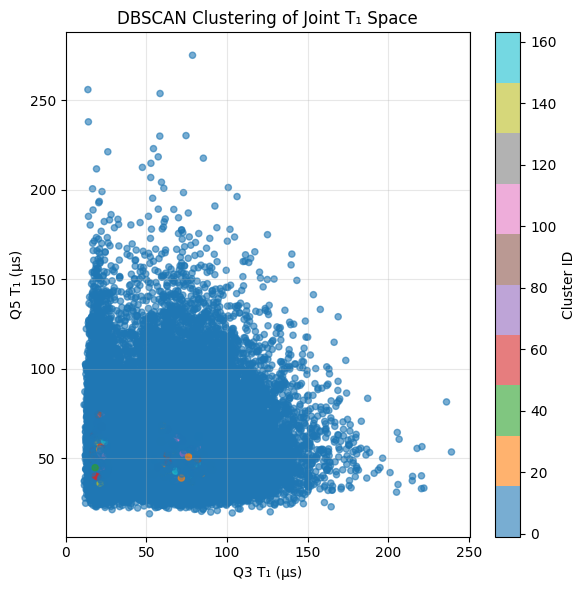

Cluster counts: {-1: 47733, 0: 48, 1: 30, 2: 15, 3: 24, 4: 18, 5: 10, 6: 18, 7: 24, 8: 10, 9: 24, 10: 15, 11: 13, 12: 10, 13: 21, 14: 32, 15: 11, 16: 13, 17: 11, 18: 23, 19: 10, 20: 16, 21: 21, 22: 27, 23: 31, 24: 18, 25: 10, 26: 11, 27: 11, 28: 14, 29: 15, 30: 10, 31: 15, 32: 13, 33: 10, 34: 20, 35: 12, 36: 10, 37: 25, 38: 20, 39: 16, 40: 10, 41: 17, 42: 10, 43: 15, 44: 26, 45: 10, 46: 22, 47: 20, 48: 24, 49: 10, 50: 20, 51: 19, 52: 16, 53: 12, 54: 11, 55: 14, 56: 19, 57: 13, 58: 13, 59: 18, 60: 10, 61: 13, 62: 17, 63: 22, 64: 12, 65: 8, 66: 10, 67: 22, 68: 17, 69: 17, 70: 23, 71: 10, 72: 10, 73: 10, 74: 16, 75: 12, 76: 12, 77: 10, 78: 14, 79: 9, 80: 10, 81: 10, 82: 10, 83: 11, 84: 30, 85: 15, 86: 11, 87: 10, 88: 10, 89: 13, 90: 16, 91: 20, 92: 13, 93: 21, 94: 14, 95: 10, 96: 10, 97: 10, 98: 16, 99: 15, 100: 14, 101: 9, 102: 9, 103: 12, 104: 10, 105: 10, 106: 14, 107: 10, 108: 10, 109: 10, 110: 13, 111: 11, 112: 10, 113: 9, 114: 17, 115: 13, 116: 12, 117: 10, 118: 10, 119: 10, 120: 13

In [38]:
# %% -------------------------------
# DBSCAN CLUSTERING IN JOINT T1 SPACE
# %% -------------------------------
from sklearn.cluster import DBSCAN

# Prepare feature space: joint T1 values
X = np.column_stack([t1_q3_us, t1_q5_us])

# Run DBSCAN clustering
# eps sets neighborhood size, min_samples is minimum cluster size
clustering = DBSCAN(eps=0.3, min_samples=10).fit(X)

labels = clustering.labels_  # -1 means noise points

# Scatter plot colored by cluster
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", alpha=0.6, s=20)
plt.xlabel("Q3 T₁ (µs)")
plt.ylabel("Q5 T₁ (µs)")
plt.title("DBSCAN Clustering of Joint T₁ Space")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: print cluster populations
unique, counts = np.unique(labels, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))

In [39]:
from sklearn.preprocessing import StandardScaler

X = np.column_stack([t1_q3_us, t1_q5_us])
X_scaled = StandardScaler().fit_transform(X)

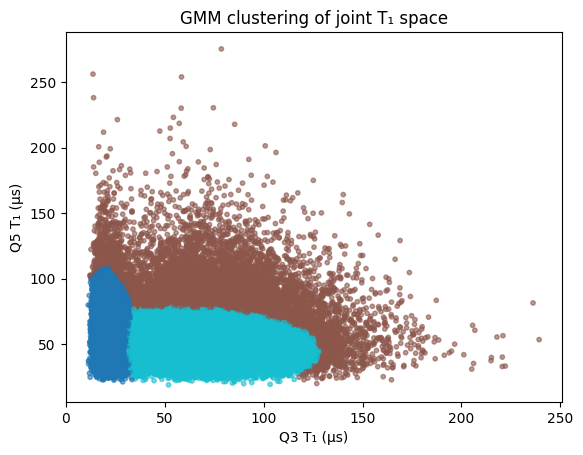

In [40]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42).fit(X_scaled)
labels = gmm.predict(X_scaled)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", s=10, alpha=0.6)
plt.xlabel("Q3 T₁ (µs)")
plt.ylabel("Q5 T₁ (µs)")
plt.title("GMM clustering of joint T₁ space")
plt.show()

## Statistical Significance Tests

Now let's determine if the observed correlations are significant or just coincidence by comparing to null models.

### 1. Permutation Test - Shuffle one signal and recompute correlations


In [41]:
# Permutation test: destroy temporal correlation by shuffling
from scipy.stats import pearsonr

# Original Pearson correlation
r_original, p_value_original = pearsonr(t1_q3_us, t1_q5_us)

# Bootstrap null distribution
n_permutations = 1000
r_null = []

np.random.seed(42)
for _ in range(n_permutations):
    # Shuffle Q5 to destroy temporal structure
    t1_q5_shuffled = np.random.permutation(t1_q5_us)
    r_shuffled, _ = pearsonr(t1_q3_us, t1_q5_shuffled)
    r_null.append(r_shuffled)

r_null = np.array(r_null)

# Compute p-value: fraction of null correlations >= observed
p_value_permutation = np.sum(np.abs(r_null) >= np.abs(r_original)) / n_permutations

print(f"Original Pearson r: {r_original:.4f} (p={p_value_original:.4e})")
print(f"Permutation test p-value: {p_value_permutation:.4f}")
print(f"Mean null correlation: {np.mean(r_null):.4f}")
print(f"Std null correlation: {np.std(r_null):.4f}")


Original Pearson r: -0.0538 (p=2.3979e-33)
Permutation test p-value: 0.0000
Mean null correlation: -0.0002
Std null correlation: 0.0045


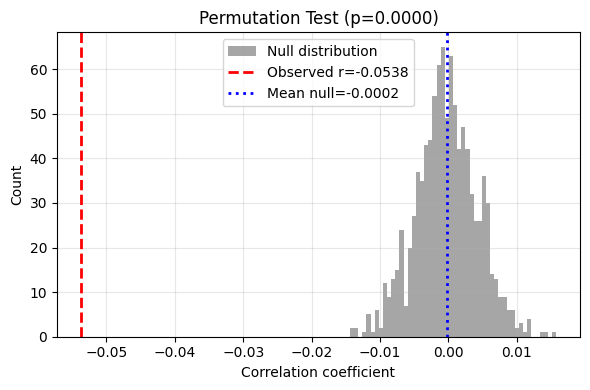

In [42]:
# Visualize permutation test
plt.figure(figsize=(6, 4))
plt.hist(r_null, bins=50, alpha=0.7, color='gray', label='Null distribution')
plt.axvline(r_original, color='red', linestyle='--', linewidth=2, label=f'Observed r={r_original:.4f}')
plt.axvline(np.mean(r_null), color='blue', linestyle=':', linewidth=2, label=f'Mean null={np.mean(r_null):.4f}')
plt.xlabel('Correlation coefficient')
plt.ylabel('Count')
plt.title(f'Permutation Test (p={p_value_permutation:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2. Time-lagged Correlation - Check if Q3 leads/lags Q5


In [ ]:
# Time-lagged cross-correlation to see if one signal leads/lags the other
max_lag_samples = 1000  # adjust based on expected lag

lags = np.arange(-max_lag_samples, max_lag_samples + 1)
cross_corr = []

for lag in lags:
    if lag < 0:
        # Q3 leads Q5
        r, _ = pearsonr(t1_q3_us[:lag], t1_q5_us[-lag:])
    elif lag > 0:
        # Q5 leads Q3
        r, _ = pearsonr(t1_q3_us[lag:], t1_q5_us[:-lag])
    else:
        # No lag
        r, _ = pearsonr(t1_q3_us, t1_q5_us)
    cross_corr.append(r)

cross_corr = np.array(cross_corr)

# Convert lags to time
lag_times = lags * np.median(np.diff(lab_time_s))

# Find peak correlation and corresponding lag
max_idx = np.argmax(np.abs(cross_corr))
peak_lag = lag_times[max_idx]
peak_corr = cross_corr[max_idx]

print(f"Peak correlation: {peak_corr:.4f} at lag: {peak_lag:.3f} s")
if peak_lag < 0:
    print(f"  → Q3 leads Q5 by {abs(peak_lag):.3f} s")
elif peak_lag > 0:
    print(f"  → Q5 leads Q3 by {peak_lag:.3f} s")
else:
    print(f"  → No significant lead/lag")


In [ ]:
# Plot lagged correlation
plt.figure(figsize=(8, 4))
plt.plot(lag_times, cross_corr, color='black', linewidth=1.5)
plt.axvline(peak_lag, color='red', linestyle='--', label=f'Peak at lag={peak_lag:.3f}s')
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Lag (s) [positive = Q5 leads Q3]')
plt.ylabel('Correlation coefficient')
plt.title('Time-lagged Cross-Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 3. Coherence Significance - Compare to shuffled baseline


In [ ]:
# Compare coherence to shuffled baseline
n_shuffles = 100
coherence_null = []

np.random.seed(42)
for i in range(n_shuffles):
    # Shuffle Q5 to destroy temporal correlation
    norm_t1_q5_shuffled = np.random.permutation(norm_t1_q5)
    
    # Recompute PSDs and CSD
    _, Pxx_shuf = welch(norm_t1_q3, fs=fs, nperseg=1024)
    _, Pyy_shuf = welch(norm_t1_q5_shuffled, fs=fs, nperseg=1024)
    _, Pxy_shuf = csd(norm_t1_q3, norm_t1_q5_shuffled, fs=fs, nperseg=1024)
    
    coherence_shuf = np.abs(Pxy_shuf) ** 2 / (Pxx_shuf * Pyy_shuf)
    coherence_null.append(coherence_shuf)

coherence_null = np.array(coherence_null)

# Compute mean and std of null coherence
coherence_null_mean = np.mean(coherence_null, axis=0)
coherence_null_std = np.std(coherence_null, axis=0)

# Z-score of observed coherence
z_score = (coherence - coherence_null_mean) / coherence_null_std

print(f"Max coherence (observed): {np.max(coherence):.4f}")
print(f"Max coherence (null mean): {np.max(coherence_null_mean):.4f}")
print(f"Max z-score: {np.max(z_score):.2f}")


In [ ]:
# Plot observed coherence vs null distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7))

# Top: Coherence comparison
ax1.semilogx(f, coherence, color='red', linewidth=2, label='Observed', alpha=0.8)
ax1.semilogx(f, coherence_null_mean, color='blue', linewidth=2, label='Null mean', alpha=0.8)
ax1.fill_between(f, 
                  coherence_null_mean - 2*coherence_null_std, 
                  coherence_null_mean + 2*coherence_null_std,
                  color='blue', alpha=0.2, label='Null ±2σ')
ax1.set_ylabel('Coherence')
ax1.set_title('Q3–Q5 Coherence vs Shuffled Baseline')
ax1.legend()
ax1.grid(True, which='both', ls='--', alpha=0.5)
ax1.set_ylim(0, 1)

# Bottom: Z-score
ax2.semilogx(f, z_score, color='black', linewidth=1.5)
ax2.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(2, color='orange', linestyle='--', alpha=0.5, label='2σ threshold')
ax2.axhline(-2, color='orange', linestyle='--', alpha=0.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Z-score')
ax2.set_title('Coherence Significance')
ax2.legend()
ax2.grid(True, which='both', ls='--', alpha=0.5)

plt.tight_layout()
plt.show()


### 4. Conditional Probability - Are extreme events correlated?


In [ ]:
# Check if extreme events in Q3 coincide with extreme events in Q5
# Define "extreme" as below 10th percentile or above 90th percentile

percentile_low = 10
percentile_high = 90

# Q3 extremes
q3_low_threshold = np.percentile(t1_q3_us, percentile_low)
q3_high_threshold = np.percentile(t1_q3_us, percentile_high)
q3_extreme_low = t1_q3_us < q3_low_threshold
q3_extreme_high = t1_q3_us > q3_high_threshold

# Q5 extremes
q5_low_threshold = np.percentile(t1_q5_us, percentile_low)
q5_high_threshold = np.percentile(t1_q5_us, percentile_high)
q5_extreme_low = t1_q5_us < q5_low_threshold
q5_extreme_high = t1_q5_us > q5_high_threshold

# Joint probabilities
p_both_low = np.sum(q3_extreme_low & q5_extreme_low) / len(t1_q3_us)
p_both_high = np.sum(q3_extreme_high & q5_extreme_high) / len(t1_q3_us)

# Individual probabilities
p_q3_low = np.sum(q3_extreme_low) / len(t1_q3_us)
p_q5_low = np.sum(q5_extreme_low) / len(t1_q5_us)
p_q3_high = np.sum(q3_extreme_high) / len(t1_q3_us)
p_q5_high = np.sum(q5_extreme_high) / len(t1_q5_us)

# Expected joint probability if independent
p_both_low_expected = p_q3_low * p_q5_low
p_both_high_expected = p_q3_high * p_q5_high

# Conditional probabilities
p_q5_low_given_q3_low = np.sum(q3_extreme_low & q5_extreme_low) / np.sum(q3_extreme_low)
p_q5_high_given_q3_high = np.sum(q3_extreme_high & q5_extreme_high) / np.sum(q3_extreme_high)

print("=" * 60)
print("EXTREME LOW T1 EVENTS (below 10th percentile)")
print("=" * 60)
print(f"P(Q3 low) = {p_q3_low:.4f}")
print(f"P(Q5 low) = {p_q5_low:.4f}")
print(f"P(both low | independent) = {p_both_low_expected:.4f}")
print(f"P(both low | observed) = {p_both_low:.4f}")
print(f"Enrichment factor = {p_both_low / p_both_low_expected:.2f}x")
print(f"P(Q5 low | Q3 low) = {p_q5_low_given_q3_low:.4f}")
print()
print("=" * 60)
print("EXTREME HIGH T1 EVENTS (above 90th percentile)")
print("=" * 60)
print(f"P(Q3 high) = {p_q3_high:.4f}")
print(f"P(Q5 high) = {p_q5_high:.4f}")
print(f"P(both high | independent) = {p_both_high_expected:.4f}")
print(f"P(both high | observed) = {p_both_high:.4f}")
print(f"Enrichment factor = {p_both_high / p_both_high_expected:.2f}x")
print(f"P(Q5 high | Q3 high) = {p_q5_high_given_q3_high:.4f}")


In [ ]:
# Visualize joint probability distribution with extreme events highlighted
fig, ax = plt.subplots(figsize=(7, 6))

# Scatter plot with extreme events colored
normal_mask = ~(q3_extreme_low | q3_extreme_high | q5_extreme_low | q5_extreme_high)
both_low = q3_extreme_low & q5_extreme_low
both_high = q3_extreme_high & q5_extreme_high

ax.scatter(t1_q3_us[normal_mask], t1_q5_us[normal_mask], 
           alpha=0.1, c='gray', s=5, label='Normal')
ax.scatter(t1_q3_us[both_low], t1_q5_us[both_low], 
           alpha=0.7, c='red', s=20, label=f'Both Low (n={np.sum(both_low)})')
ax.scatter(t1_q3_us[both_high], t1_q5_us[both_high], 
           alpha=0.7, c='blue', s=20, label=f'Both High (n={np.sum(both_high)})')

# Draw threshold lines
ax.axvline(q3_low_threshold, color='red', linestyle='--', alpha=0.5)
ax.axvline(q3_high_threshold, color='blue', linestyle='--', alpha=0.5)
ax.axhline(q5_low_threshold, color='red', linestyle='--', alpha=0.5)
ax.axhline(q5_high_threshold, color='blue', linestyle='--', alpha=0.5)

ax.set_xlabel('Q3 T₁ (µs)')
ax.set_ylabel('Q5 T₁ (µs)')
ax.set_title('Joint T₁ Distribution with Extreme Events')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 5. Compare Across Multiple Datasets - Are correlations consistent over time?


In [ ]:
# Analyze correlation metrics across all datasets
import glob

# Get all dataset directories
dataset_dirs = sorted(glob.glob("BayesianEstimationDecayRate_*"))
dataset_dirs = [d for d in dataset_dirs if os.path.isdir(d)]

print(f"Found {len(dataset_dirs)} datasets")

# Store metrics for each dataset
metrics = {
    'timestamp': [],
    'pearson_r': [],
    'p_value': [],
    'enrichment_low': [],
    'enrichment_high': [],
    'max_coherence': [],
    'peak_lag': []
}

for data_dir in dataset_dirs:
    try:
        # Extract timestamp from directory name
        timestamp = data_dir.split('_')[-1]
        
        # Load data
        data_temp = xr.open_zarr(os.path.join(data_dir, "raw_data.zarr"))
        
        # Extract T1 values
        theta_q3_temp = np.reshape(
            data_temp.q3_theta.values.flatten(),
            (len(data_temp.q3_theta.values.flatten()) // (data_temp.shots.values[-1] + 1),
             data_temp.shots.values[-1] + 1)
        )
        k_q3_temp = np.reshape(
            data_temp.q3_k.values.flatten(),
            (len(data_temp.q3_k.values.flatten()) // (data_temp.shots.values[-1] + 1),
             data_temp.shots.values[-1] + 1)
        )
        theta_q5_temp = np.reshape(
            data_temp.q5_theta.values.flatten(),
            (len(data_temp.q5_theta.values.flatten()) // (data_temp.shots.values[-1] + 1),
             data_temp.shots.values[-1] + 1)
        )
        k_q5_temp = np.reshape(
            data_temp.q5_k.values.flatten(),
            (len(data_temp.q5_k.values.flatten()) // (data_temp.shots.values[-1] + 1),
             data_temp.shots.values[-1] + 1)
        )
        
        t1_q3_temp = (theta_q3_temp / (16 * k_q3_temp) * 1e6)[:, -1]
        t1_q5_temp = (theta_q5_temp / (16 * k_q5_temp) * 1e6)[:, -1]
        
        lab_time_temp = np.reshape(
            data_temp.q3__timestamp.values.flatten(),
            (len(data_temp.q3__timestamp.values.flatten()) // (data_temp.shots.values[-1] + 1),
             data_temp.shots.values[-1] + 1)
        )[:, 0]
        
        # 1. Pearson correlation
        r, p = pearsonr(t1_q3_temp, t1_q5_temp)
        
        # 2. Enrichment factors for extreme events
        q3_low_th = np.percentile(t1_q3_temp, 10)
        q3_high_th = np.percentile(t1_q3_temp, 90)
        q5_low_th = np.percentile(t1_q5_temp, 10)
        q5_high_th = np.percentile(t1_q5_temp, 90)
        
        q3_ext_low = t1_q3_temp < q3_low_th
        q3_ext_high = t1_q3_temp > q3_high_th
        q5_ext_low = t1_q5_temp < q5_low_th
        q5_ext_high = t1_q5_temp > q5_high_th
        
        p_both_low = np.sum(q3_ext_low & q5_ext_low) / len(t1_q3_temp)
        p_both_high = np.sum(q3_ext_high & q5_ext_high) / len(t1_q3_temp)
        p_q3_low = np.sum(q3_ext_low) / len(t1_q3_temp)
        p_q5_low = np.sum(q5_ext_low) / len(t1_q5_temp)
        p_q3_high = np.sum(q3_ext_high) / len(t1_q3_temp)
        p_q5_high = np.sum(q5_ext_high) / len(t1_q5_temp)
        
        enrich_low = p_both_low / (p_q3_low * p_q5_low) if (p_q3_low * p_q5_low) > 0 else 0
        enrich_high = p_both_high / (p_q3_high * p_q5_high) if (p_q3_high * p_q5_high) > 0 else 0
        
        # 3. Coherence
        norm_t1_q3_temp = (t1_q3_temp - np.mean(t1_q3_temp)) / np.mean(t1_q3_temp)
        norm_t1_q5_temp = (t1_q5_temp - np.mean(t1_q5_temp)) / np.mean(t1_q5_temp)
        fs_temp = 1.0 / np.median(np.diff(lab_time_temp))
        
        f_temp, Pxx_temp = welch(norm_t1_q3_temp, fs=fs_temp, nperseg=min(1024, len(norm_t1_q3_temp)//4))
        _, Pyy_temp = welch(norm_t1_q5_temp, fs=fs_temp, nperseg=min(1024, len(norm_t1_q5_temp)//4))
        _, Pxy_temp = csd(norm_t1_q3_temp, norm_t1_q5_temp, fs=fs_temp, nperseg=min(1024, len(norm_t1_q3_temp)//4))
        
        coherence_temp = np.abs(Pxy_temp) ** 2 / (Pxx_temp * Pyy_temp)
        max_coh = np.max(coherence_temp)
        
        # 4. Peak lag
        max_lag = min(1000, len(t1_q3_temp)//4)
        lags_temp = np.arange(-max_lag, max_lag + 1)
        cross_corr_temp = []
        for lag in lags_temp:
            if lag < 0:
                r_lag, _ = pearsonr(t1_q3_temp[:lag], t1_q5_temp[-lag:])
            elif lag > 0:
                r_lag, _ = pearsonr(t1_q3_temp[lag:], t1_q5_temp[:-lag])
            else:
                r_lag, _ = pearsonr(t1_q3_temp, t1_q5_temp)
            cross_corr_temp.append(r_lag)
        
        cross_corr_temp = np.array(cross_corr_temp)
        max_idx = np.argmax(np.abs(cross_corr_temp))
        peak_lag_time = lags_temp[max_idx] * np.median(np.diff(lab_time_temp))
        
        # Store metrics
        metrics['timestamp'].append(timestamp)
        metrics['pearson_r'].append(r)
        metrics['p_value'].append(p)
        metrics['enrichment_low'].append(enrich_low)
        metrics['enrichment_high'].append(enrich_high)
        metrics['max_coherence'].append(max_coh)
        metrics['peak_lag'].append(peak_lag_time)
        
        print(f"✓ {timestamp}: r={r:.3f}, p={p:.2e}, enrich_low={enrich_low:.2f}x, enrich_high={enrich_high:.2f}x")
        
    except Exception as e:
        print(f"✗ {timestamp}: Error - {e}")
        continue

print(f"\nSuccessfully analyzed {len(metrics['timestamp'])} datasets")


In [ ]:
# Visualize metrics across datasets
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Convert timestamps to integers for x-axis
x_vals = np.arange(len(metrics['timestamp']))

# Plot 1: Pearson correlation
axes[0, 0].plot(x_vals, metrics['pearson_r'], 'o-', color='black', markersize=6)
axes[0, 0].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].set_ylabel('Pearson r')
axes[0, 0].set_title('Correlation Strength Across Datasets')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: P-value (log scale)
axes[0, 1].semilogy(x_vals, metrics['p_value'], 'o-', color='red', markersize=6)
axes[0, 1].axhline(0.05, color='orange', linestyle='--', label='p=0.05')
axes[0, 1].axhline(0.001, color='red', linestyle='--', label='p=0.001')
axes[0, 1].set_ylabel('P-value')
axes[0, 1].set_title('Statistical Significance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, which='both')

# Plot 3: Enrichment factors
axes[1, 0].plot(x_vals, metrics['enrichment_low'], 'o-', color='red', 
                markersize=6, label='Low T1 events')
axes[1, 0].plot(x_vals, metrics['enrichment_high'], 's-', color='blue', 
                markersize=6, label='High T1 events')
axes[1, 0].axhline(1, color='gray', linestyle='--', alpha=0.5, label='Independent')
axes[1, 0].set_ylabel('Enrichment Factor')
axes[1, 0].set_title('Extreme Event Co-occurrence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Max coherence
axes[1, 1].plot(x_vals, metrics['max_coherence'], 'o-', color='purple', markersize=6)
axes[1, 1].set_ylabel('Max Coherence')
axes[1, 1].set_title('Peak Spectral Coherence')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Peak lag
axes[2, 0].plot(x_vals, metrics['peak_lag'], 'o-', color='green', markersize=6)
axes[2, 0].axhline(0, color='gray', linestyle=':', alpha=0.5)
axes[2, 0].set_ylabel('Peak Lag (s)')
axes[2, 0].set_xlabel('Dataset Index')
axes[2, 0].set_title('Optimal Time Lag')
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Summary statistics
axes[2, 1].axis('off')
summary_text = f"""
SUMMARY STATISTICS (N={len(metrics['timestamp'])} datasets)

Pearson Correlation:
  Mean: {np.mean(metrics['pearson_r']):.3f} ± {np.std(metrics['pearson_r']):.3f}
  Range: [{np.min(metrics['pearson_r']):.3f}, {np.max(metrics['pearson_r']):.3f}]

Significant correlations (p<0.05): {np.sum(np.array(metrics['p_value']) < 0.05)} / {len(metrics['p_value'])}

Enrichment (Low T1):
  Mean: {np.mean(metrics['enrichment_low']):.2f}x ± {np.std(metrics['enrichment_low']):.2f}x

Enrichment (High T1):
  Mean: {np.mean(metrics['enrichment_high']):.2f}x ± {np.std(metrics['enrichment_high']):.2f}x

Max Coherence:
  Mean: {np.mean(metrics['max_coherence']):.3f} ± {np.std(metrics['max_coherence']):.3f}
"""
axes[2, 1].text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


## Interpretation Guide: Real Correlation vs Coincidence

**How to interpret these results:**

1. **Permutation Test** (Cell 24-25):
   - If p-value < 0.05 → Correlation is statistically significant
   - If observed correlation is far outside the null distribution → Evidence for real correlation

2. **Time-lagged Correlation** (Cell 27-28):
   - If peak is at lag ≈ 0 → Simultaneous correlation (common cause)
   - If peak is at lag ≠ 0 → One signal may lead the other (causal relationship)
   - If correlation is weak at all lags → Likely coincidence

3. **Coherence Significance** (Cell 30-31):
   - If observed coherence >> null coherence (z-score > 2) → Real frequency-specific correlation
   - If z-score < 2 everywhere → Correlations could be noise

4. **Conditional Probability** (Cell 33-34):
   - If enrichment factor >> 1 → Extreme events co-occur more than expected by chance
   - If enrichment factor ≈ 1 → Events are independent (coincidence)

5. **Cross-Dataset Consistency** (Cell 36-37):
   - If correlation metrics are consistent across datasets → Strong evidence for real correlation
   - If metrics vary randomly across datasets → Likely coincidence or unstable relationship

**Decision criteria:**
- ✅ **REAL CORRELATION** if: p < 0.05 AND enrichment > 1.5 AND consistent across datasets
- ⚠️ **WEAK/UNSTABLE** if: Some metrics significant but inconsistent across datasets  
- ❌ **LIKELY COINCIDENCE** if: p > 0.05 OR enrichment ≈ 1 OR inconsistent across datasets
